In [1]:
import os
import sys
import importlib
# Add utilities to path (utilities is one directory down from this notebook)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))
import time
import fitz
import utilities.pdf_extraction_utils
import json
importlib.reload(utilities.pdf_extraction_utils)
from utilities.pdf_extraction_utils import (
    ExtractionConfig,
    load_pdf_page,
    analyze_layers,
    extract_polygons_from_layer,
    batch_extract_polygons,
    visualize_extraction_results,
    save_polygons_to_json,
    load_polygons_from_json,
    build_clip_map,
    filter_layer_paths,
    extract_lines_from_paths,
    cluster_and_snap_endpoints,
    extend_dangles,
    polygonize_lines,
    plot_polygons_on_pdf,
    get_buffered_polygon_bounds,
    draw_polygon_on_page,
    clip_pdf_to_polygon,
    get_label_from_gemini,
    get_page_label_from_gemini,
    process_elements_on_page,
    build_layout_geojson,
    extract_page_elements

)

from utilities.coordinate_transformation import (
    align_multilinestrings_by_convex_hull, 
    compose_affine
)

from shapely.affinity import affine_transform








c:\Users\roba7\Documents\Programming projects\as-built-processing\pdf_layout_extraction_dev\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
test_pdf = "C:/Users/roba7/Documents/Programming projects/as-built-processing/pdf_layout_extraction_dev/docs/full_pdf/NorthStar As Built - Rev 2 2016-11-15.pdf"
test_layer = "E-CB_AREA"
config = ExtractionConfig()
file_path = test_pdf
layer_name = test_layer
page_number = 14
# Layerrs to carry into model:
layers_dict = {
    'rack_outlines':        {'layer': "Xpanels - Northstar|E-PLAN-MCB",         'type': 'polygon', 'fill_lines': False},
    'combiner_boxes':       {'layer': "E-CB",                                   'type': 'rectangle', 'fill_lines': True},
    'ug_conduit':           {'layer': "E-UG_CONDUIT",                           'type': 'line', 'fill_lines': True},
    'ug_conduit_34.5kv':    {'layer': "E-UG_CONDUIT-34.5kV",                    'type': 'line', 'fill_lines': True},
    'ug_conduit_34.5kv_1ckt': {'layer': "E-UG_CONDUIT-34.5kV_1ckt",             'type': 'line', 'fill_lines': True},
    'inverter_boxed':       {'layer': "Xpanels - Northstar|E-Equipment",        'type': 'rectangle', 'fill_lines': False},
    'combiner_outlines':    {'layer': "E-CB_AREA",                              'type': 'polygon', 'fill_lines': True}
}

layout_layer_name = "Xpanels - Northstar|M-PLAN-TRACKER OUTLINE"

output_dir = None
token_master_sum = 0
#step 1: Get inverter layout
layer_name = "key plan|BEI-BLOCK-OUTLINE"
page_number = 14
config.extension_length = 20
element_type = "inverter"
inverter_result = extract_polygons_from_layer(file_path, page_number, layer_name, config)
inverter_label_poly_dict, token_total = process_elements_on_page(file_path, page_number, inverter_result['polygons'], element_type,output_dir)
inverter_label_poly_dict = {k.strip(): v for k, v in inverter_label_poly_dict.items()}
token_master_sum += token_total
doc_json = {}

def process_page(page_number):
    print(f"Processing page {page_number}")
    doc = fitz.open(file_path)
    page = doc[page_number]
    img_bytes = page.get_pixmap(dpi=300).tobytes("png")
    label, token_count = get_page_label_from_gemini(img_bytes)

    layer_name = "combiner_outlines"
    element_type = "combiner"
    #result = extract_polygons_from_layer(file_path, page_number, layer_name, config)
    page_elements = extract_page_elements(file_path, page_number, config, layers_dict)

    combiner_label_poly_dict, token_total = process_elements_on_page(file_path, page_number, page_elements["combiner_outlines"], element_type, output_dir)
    return (page_number, label, page_elements, combiner_label_poly_dict, token_total)

page_start = 14
page_end = 15
config.extension_length = 40
page_numbers = list(range(page_start, page_end))

results = []
import pickle

for page_number in page_numbers:
    page_number, label, page_elements, combiner_label_poly_dict, token_total = process_page(page_number)
    token_master_sum += token_total
    doc_json[page_number] = {
        "page_label": label,
        "page_number": page_number,
        "page_elements": page_elements,
        "combiner_label_poly_dict": combiner_label_poly_dict,
    }
    with open(f"layout_extended_{page_start}_{page_end}_running_record.pkl", "wb") as f:
        pickle.dump(doc_json, f)
estimated_cost = token_master_sum * 0.40 / 1_000_000
print(f"Total tokens: {token_master_sum}, Estimated processing cost: ${estimated_cost:.6f}")

    # Step 4: Get combiner layout
"""
geojson_fc = build_layout_geojson(
    base_polys=inverter_label_poly_dict,
    pages=doc_json,
    key_normalizer=lambda s: s.strip(),  # trims the leading space in base keys like " 1.2"
    keep_aspect=True,                    # preserves page aspect ratio
    center=True,                         # centers within the base cell bbox
    include_base_cells=True,
    transform_to_base=True
)

with open(f"layout_extended_{page_start}_{page_end}_transform_to_base.geojson", "w") as f:
    json.dump(geojson_fc, f)

geojson_fc_not_transformed = build_layout_geojson(
    base_polys=inverter_label_poly_dict,
    pages=doc_json,
    key_normalizer=lambda s: s.strip(),  # trims the leading space in base keys like " 1.2"
    keep_aspect=True,                    # preserves page aspect ratio
    center=True,                         # centers within the base cell bbox
    include_base_cells=True,
    transform_to_base=False
)

with open(f"layout_extended_{page_start}_{page_end}.geojson", "w") as f:
    json.dump(geojson_fc, f)
"""


Processing page 14


c:\Users\roba7\Documents\Programming projects\as-built-processing\pdf_layout_extraction_dev\.venv\Lib\site-packages\PIL\Image.py:3452: DecompressionBombWarning: Image size (113400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


```json
{"inverter_block_number": " 1.2"}
```
Total tokens: 36506, Estimated processing cost: $0.014602


'\ngeojson_fc = build_layout_geojson(\n    base_polys=inverter_label_poly_dict,\n    pages=doc_json,\n    key_normalizer=lambda s: s.strip(),  # trims the leading space in base keys like " 1.2"\n    keep_aspect=True,                    # preserves page aspect ratio\n    center=True,                         # centers within the base cell bbox\n    include_base_cells=True,\n    transform_to_base=True\n)\n\nwith open(f"layout_extended_{page_start}_{page_end}_transform_to_base.geojson", "w") as f:\n    json.dump(geojson_fc, f)\n\ngeojson_fc_not_transformed = build_layout_geojson(\n    base_polys=inverter_label_poly_dict,\n    pages=doc_json,\n    key_normalizer=lambda s: s.strip(),  # trims the leading space in base keys like " 1.2"\n    keep_aspect=True,                    # preserves page aspect ratio\n    center=True,                         # centers within the base cell bbox\n    include_base_cells=True,\n    transform_to_base=False\n)\n\nwith open(f"layout_extended_{page_start}_{page

In [46]:
inverter_label_poly_dict = {k.strip(): v for k, v in inverter_label_poly_dict.items()}

In [52]:
doc_json[page_number]['page_label'].strip()

'1.2'

In [53]:
# Load site layout
from shapely.geometry import MultiLineString, mapping
import importlib, align_racking_v2
import json
import utilities.pdf_extraction_utils
importlib.reload(utilities.pdf_extraction_utils)
from utilities.pdf_extraction_utils import (
    ExtractionConfig,
    load_pdf_page,
    filter_layer_paths,
    extract_lines_from_paths
)
importlib.reload(utilities.pdf_extraction_utils)
importlib.reload(align_racking_v2)
from shapely.ops import polygonize

def geometry_to_feature(geom, properties=None):
    """Convert a shapely geometry and properties to a GeoJSON feature."""
    return {
        "type": "Feature",
        "geometry": mapping(geom),
        "properties": properties or {}
    }
page_number = 1
page, drawings = load_pdf_page(test_pdf, page_number)
layer_name = "Xpanels - Northstar|M-PLAN-TRACKER OUTLINE"
layer_paths = filter_layer_paths(drawings, layer_name)
config = ExtractionConfig()
layout_lines = extract_lines_from_paths(layer_paths, config)
site_polygons = list(polygonize(layout_lines))

mls = MultiLineString([list(line.coords) for line in layout_lines])

all_features = []

# Add site polygons to features
for idx, poly in enumerate(site_polygons):
    all_features.append(geometry_to_feature(poly, {"type": "site_polygon", "index": idx}))

# Add full site inverter polygons (from inverter_result['polygons']) to features
for idx, poly in enumerate(inverter_result['polygons']):
    label = None
    # Try to find the label for this inverter polygon
    for k, v in inverter_label_poly_dict.items():
        if v.equals(poly):
            label = k
            break
    props = {"type": "inverter_full_site", "index": idx}
    if label is not None:
        props["label"] = label
        # Add any extra metadata from inverter_label_poly_dict
        if isinstance(inverter_label_poly_dict[label], dict):
            props.update({k: v for k, v in inverter_label_poly_dict[label].items() if k != "geometry"})
    all_features.append(geometry_to_feature(poly, props))

# Load inverter layout and transform page elements
for page_number in page_numbers:
    combiners = doc_json[page_number]['page_elements']['combiner_outlines']
    inverter_outline = inverter_label_poly_dict[doc_json[page_number]['page_label'].strip()]
    mls_inverter = MultiLineString([list(inverter_outline.exterior.coords)])

    mls_combiners = MultiLineString([list(poly.exterior.coords) for poly in combiners])
    hull_combiners = mls_combiners.convex_hull

    affine_params_combiner_to_inverter, transformed_source_combiner_outlines = align_multilinestrings_by_convex_hull(
        mls_combiners, mls_inverter, scale_mode='fit'
    )

    mls_inverter_full_site = MultiLineString([list(poly.exterior.coords) for poly in inverter_result['polygons']])

    affine_params_inverter_to_site, transformed_source = align_multilinestrings_by_convex_hull(
        mls_inverter_full_site, mls, scale_mode='fit'
    )

    transformed_source_combiner_outlines_site = affine_transform(transformed_source_combiner_outlines, affine_params_inverter_to_site)

    affine_params_combiner_to_site = compose_affine(affine_params_combiner_to_inverter, affine_params_inverter_to_site)
    combiner_poly_site = affine_transform(mls_combiners, affine_params_combiner_to_site)

    
    with open("layout_extended_13_63_running_record.pkl", "rb") as f:
        doc_json_v2 = pickle.load(f)

    rack_outlines = doc_json[page_number]['page_elements']['rack_outlines']
    #mls_rack_outlines = MultiLineString([list(poly.exterior.coords) for poly in rack_outlines])
    #rack_outlines_transformed = affine_transform(mls_rack_outlines, affine_params_combiner_to_site)
    rack_outlines_transformed = [affine_transform(poly, affine_params_combiner_to_site) for poly in rack_outlines]



    params, out_mls, aoi = align_racking_v2.align_by_width_edge_rows(
        combiner_poly_site, site_polygons, rack_outlines_transformed, row_shift_range=3
    )

    fine_tune_affine = params['affine']

    combiner_poly_site_transformed = affine_transform(combiner_poly_site, fine_tune_affine)

    # Compose the final affine: combiner->site, then fine-tune
    composed_affine = compose_affine(affine_params_combiner_to_site, fine_tune_affine)

    # Apply to all other elements in page_elements
    transformed_page_elements = {}
    for key, value in doc_json[page_number]['page_elements'].items():
        if key in ['combiner_outlines', 'rack_outlines']:
            # List of polygons
            transformed_page_elements[key] = [affine_transform(poly, composed_affine) for poly in value]
        elif key.endswith('_points'):
            # List of points
            transformed_page_elements[key] = [affine_transform(pt, composed_affine) for pt in value]
        elif hasattr(value, 'geom_type'):
            # Single geometry (Polygon, LineString, etc.)
            transformed_page_elements[key] = affine_transform(value, composed_affine)
        else:
            # Leave as is (non-geometry)
            transformed_page_elements[key] = value

    # Save all transformed elements as GeoJSON features, preserving metadata
    for key, value in transformed_page_elements.items():
        if isinstance(value, list):
            for idx, geom in enumerate(value):
                if hasattr(geom, 'geom_type'):
                    props = {
                        "type": key,
                        "page_number": page_number,
                        "page_label": doc_json[page_number]['page_label'],
                        "element_index": idx
                    }
                    # Add any extra metadata from doc_json
                    if "metadata" in doc_json[page_number]:
                        props.update(doc_json[page_number]["metadata"])
                    all_features.append(geometry_to_feature(geom, props))
        elif hasattr(value, 'geom_type'):
            props = {
                "type": key,
                "page_number": page_number,
                "page_label": doc_json[page_number]['page_label']
            }
            if "metadata" in doc_json[page_number]:
                props.update(doc_json[page_number]["metadata"])
            all_features.append(geometry_to_feature(value, props))

# Write all features to a GeoJSON file
geojson_out = {
    "type": "FeatureCollection",
    "features": all_features
}

from datetime import datetime
now_str = datetime.now().strftime("%Y%m%d_%H%M%S")
with open(f"layout_transformed_{page_start}_{page_end}_all_{now_str}.geojson", "w") as f:
    json.dump(geojson_out, f)


target width, source width 1.199951171875 1.1565102291438052
scale 1.0375620912262533
target pitch, source pitch, selected pitch 4.0 4.0 4.0
k -3
overlap 138
k -2
overlap 140
k -1
overlap 140
k 0
overlap 140
k 1
overlap 139
k 2
overlap 138
k 3
overlap 136
best_overlap 140
best_k -2


c:\Users\roba7\Documents\Programming projects\as-built-processing\pdf_layout_extraction_dev\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


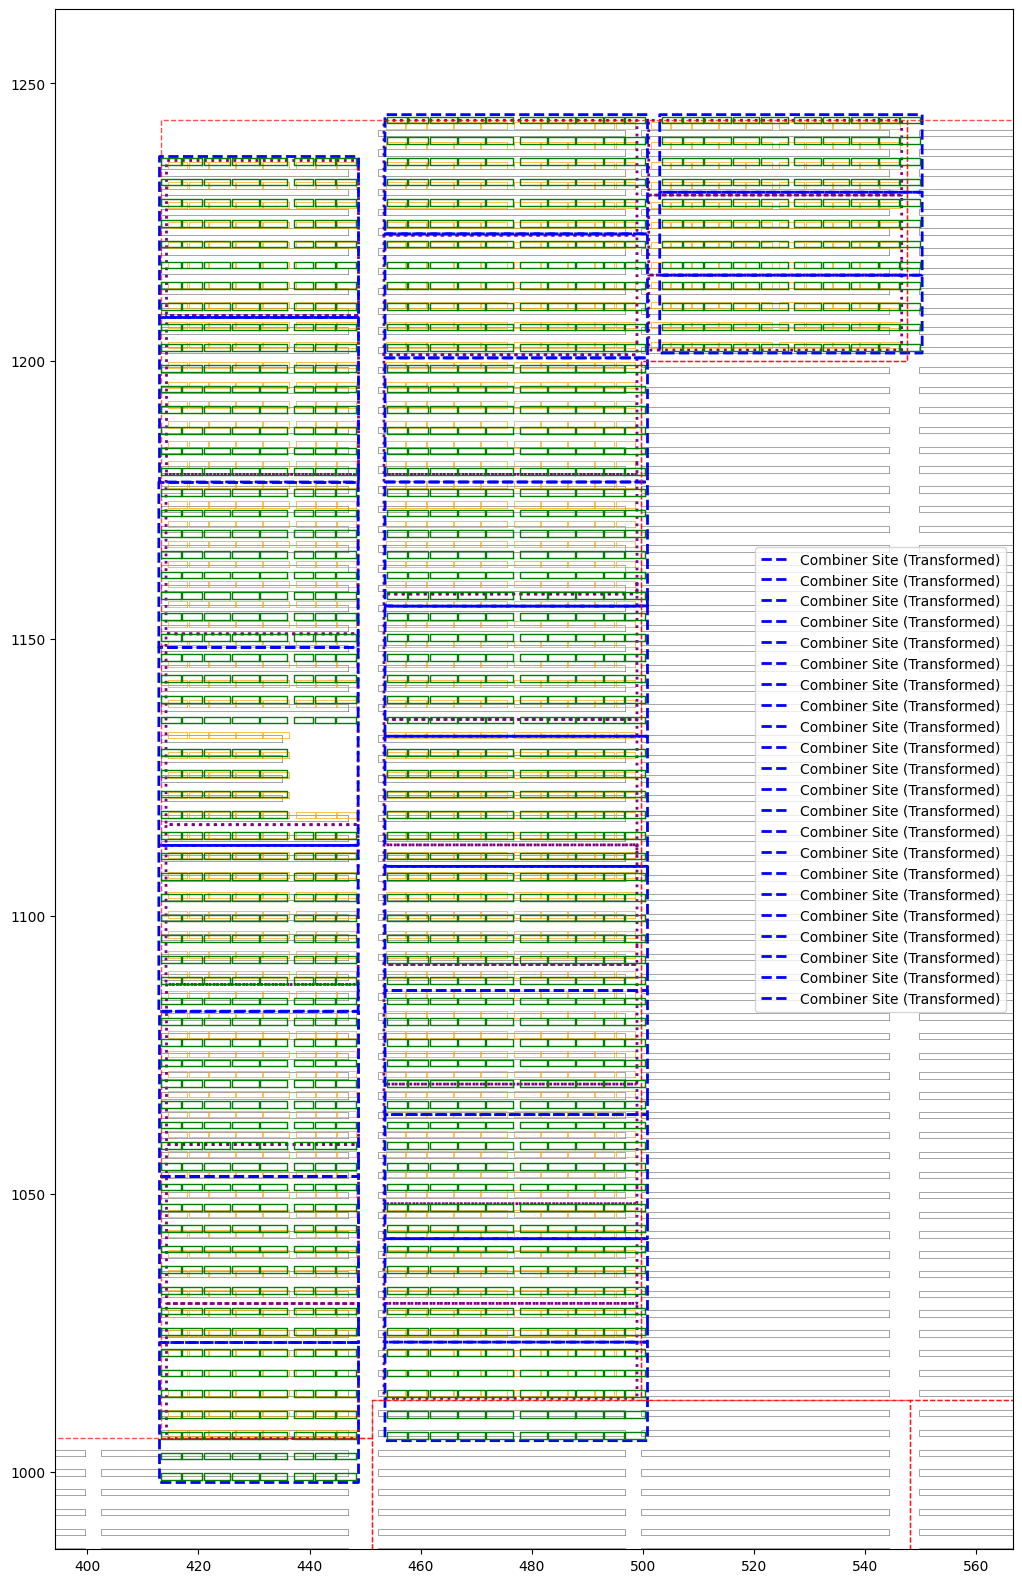

In [54]:
import matplotlib.pyplot as plt

import importlib, align_racking_v2
importlib.reload(align_racking_v2)




fig, ax = plt.subplots(figsize=(20, 20))
all_x = []
all_y = []

# Plot polygons
for poly in site_polygons:
    x, y = poly.exterior.xy
    ax.plot(x, y, color='grey', linewidth=0.5)
    all_x.extend(x)
    all_y.extend(y)

# Plot rack_outlines_transformed
for poly in rack_outlines_transformed:
    x, y = poly.exterior.xy
    ax.plot(x, y, color='orange', linewidth=0.5)


# Plot combiner_poly_site (MultiLineString)
for line in combiner_poly_site.geoms:
    x, y = line.xy
    ax.plot(x, y, color='purple', linewidth=2, linestyle=':')

from shapely import affinity


# Plot transformed combiner_poly_site
for line in combiner_poly_site_transformed.geoms:
    x, y = line.xy
    ax.plot(x, y, color='blue', linewidth=2, linestyle='--', label='Combiner Site (Transformed)')


# Plot transformed source MultiLineString
for line in transformed_source.geoms:
    x, y = line.xy
    ax.plot(x, y, color='red', linewidth=1, alpha=0.7, linestyle='--')

# Plot out_mls
if out_mls.geom_type == 'MultiLineString':
    for line in out_mls.geoms:
        x, y = line.xy
        ax.plot(x, y, color='green', linewidth=1, linestyle='-')
elif out_mls.geom_type == 'LineString':
    x, y = out_mls.xy
    ax.plot(x, y, color='green', linewidth=1, linestyle='-')

min_x, max_x = min(all_x), max(all_x)
min_y, max_y = min(all_y), max(all_y)
width = max_x - min_x
height = max_y - min_y
# Set xlim, ylim to combiner_poly_site bounds plus 20 buffer
minx, miny, maxx, maxy = combiner_poly_site.bounds
ax.set_xlim(minx - 20, maxx + 20)
ax.set_ylim(miny - 20, maxy + 20)
ax.set_aspect('equal')
ax.legend()
plt.show()

In [ ]:
target width, source width 1.199951171875 1.2067932825848402
scale 0.9943303374251595
k -3
k -2
k -1
k 0
k 1
k 2
k 3
best_overlap 140
best_k 0

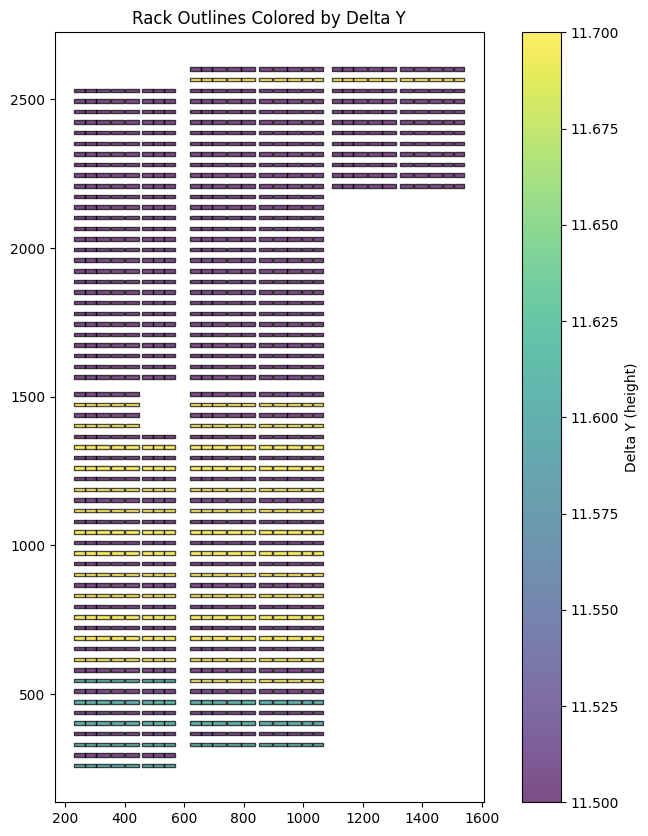

In [27]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon
import numpy as np

rack_outlines = doc_json[14]['page_elements']['rack_outlines']

# Compute delta y (max y - min y) for each rack
delta_ys = []
for poly in rack_outlines:
    if hasattr(poly, "exterior"):
        ys = [pt[1] for pt in poly.exterior.coords]
        delta_ys.append(max(ys) - min(ys))
    else:
        delta_ys.append(0)

fig, ax = plt.subplots(figsize=(10, 10))
patches = []
for poly in rack_outlines:
    if hasattr(poly, "exterior"):
        patches.append(plt.Polygon(list(poly.exterior.coords), closed=True))

# Normalize delta_ys for colormap
delta_ys_arr = np.array(delta_ys)
norm = plt.Normalize(delta_ys_arr.min(), delta_ys_arr.max())
cmap = plt.cm.viridis

p = PatchCollection(patches, cmap=cmap, edgecolor='k', alpha=0.7)
p.set_array(delta_ys_arr)
ax.add_collection(p)
fig.colorbar(p, ax=ax, label="Delta Y (height)")

ax.autoscale()
ax.set_aspect('equal')
plt.title("Rack Outlines Colored by Delta Y")
plt.show()


In [29]:
file_path = "C:/Users/roba7/Documents/Programming projects/as-built-processing/pdf_layout_extraction_dev/docs/full_pdf/NorthStar As Built - Rev 2 2016-11-15.pdf"
page_number = 14
doc = fitz.open(file_path)
page = doc[page_number]
drawings = page.get_drawings()

layer_name = "Xpanels - Northstar|E-PLAN-MCB"
layer_paths = filter_layer_paths(drawings, layer_name)

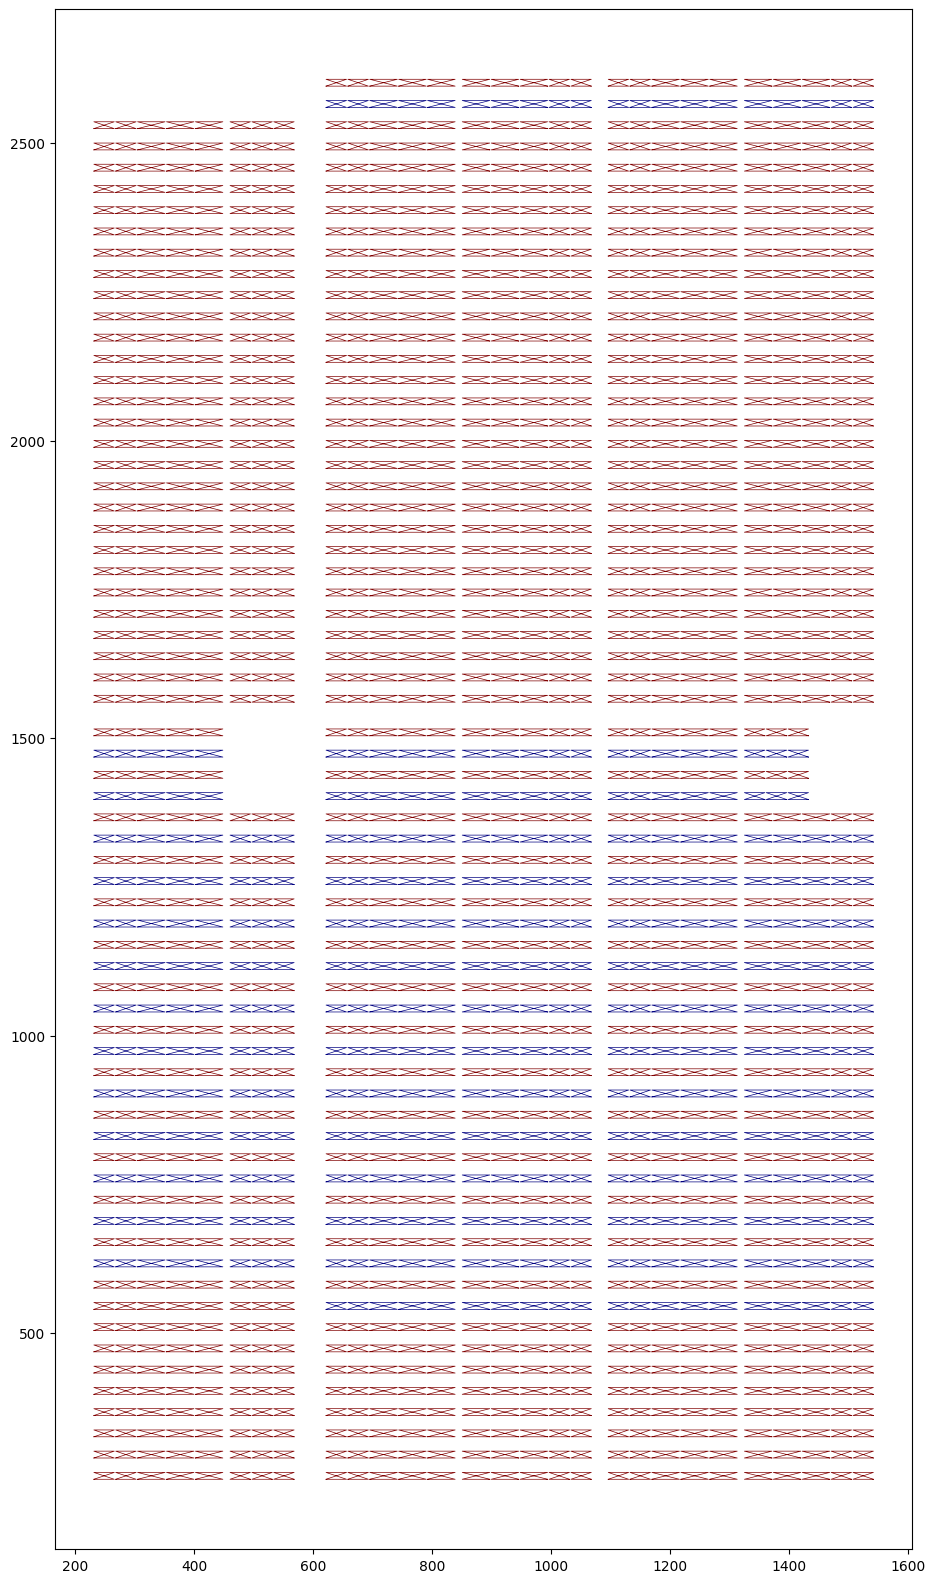

[-11.5198974609375,
 -11.64013671875,
 -11.6400146484375,
 -11.52001953125,
 -11.639892578125]

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Collect all quad heights
quad_heights = []
quads = []
for path in layer_paths:
    for item in path.get("items", []):
        if item[0] == "qu":
            quad = item[1]
            pts = [quad[0], quad[1], quad[2], quad[3]]
            width = pts[0].y - pts[2].y
            height = ((pts[1].x - pts[2].x)**2 + (pts[1].y - pts[2].y)**2) ** 0.5
            quad_heights.append(width)
            quads.append((quad, width))

# Normalize heights for colormap
heights_arr = np.array(quad_heights)
if len(heights_arr) > 0:
    min_h, max_h = heights_arr.min(), heights_arr.max()
    norm = plt.Normalize(min_h, max_h) if max_h > min_h else lambda x: 0.5
else:
    norm = lambda x: 0.5

cmap = plt.get_cmap("jet")

fig, ax = plt.subplots(figsize=(20, 20))
for quad, height in quads:
    xs = [pt.x for pt in quad] + [quad[0].x]
    ys = [pt.y for pt in quad] + [quad[0].y]
    color = cmap(norm(height))
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_aspect("equal")
plt.show()
list(set(quad_heights))

In [38]:
file_path = "C:/Users/roba7/Documents/Programming projects/as-built-processing/pdf_layout_extraction_dev/docs/full_pdf/NorthStar As Built - Rev 2 2016-11-15.pdf"
page_number = 24
doc = fitz.open(file_path)
page = doc[page_number]
drawings = page.get_drawings()

layer_name = "Xpanels - Northstar|E-PLAN-MCB"
layer_paths = filter_layer_paths(drawings, layer_name)

In [72]:
layer_paths

[{'items': [('qu',
    Quad(Point(791.719970703125, 254.43994140625), Point(838.1599731445312, 254.43994140625), Point(791.719970703125, 265.9599609375), Point(838.1599731445312, 265.9599609375)))],
  'type': 's',
  'stroke_opacity': 1.0,
  'color': (0.0, 0.0, 0.0),
  'width': 0.11999999731779099,
  'lineCap': (1, 1, 1),
  'lineJoin': 0.11999999731779099,
  'closePath': False,
  'dashes': '[] 0',
  'rect': Rect(791.719970703125, 254.43994140625, 838.1599731445312, 265.9599609375),
  'layer': 'Xpanels - Northstar|E-PLAN-MCB',
  'seqno': 2220,
  'fill': None,
  'fill_opacity': None,
  'even_odd': None},
 {'items': [('qu',
    Quad(Point(743.1199951171875, 254.43994140625), Point(789.5599975585938, 254.43994140625), Point(743.1199951171875, 265.9599609375), Point(789.5599975585938, 265.9599609375)))],
  'type': 's',
  'stroke_opacity': 1.0,
  'color': (0.0, 0.0, 0.0),
  'width': 0.11999999731779099,
  'lineCap': (1, 1, 1),
  'lineJoin': 0.11999999731779099,
  'closePath': False,
  'dashes

In [68]:
pts

[Point(230.83999633789062, 1396.840087890625),
 Point(265.2799987792969, 1396.840087890625),
 Point(230.83999633789062, 1408.47998046875),
 Point(265.2799987792969, 1408.47998046875)]

In [5]:
widths = []
heights = []
for path in layer_paths:
    for item in path.get("items", []):
        if item[0] == "qu":
            quad = item[1]
            pts = [quad[0], quad[1], quad[2], quad[3]]
            width = ((pts[0].x - pts[1].x)**2 + (pts[0].y - pts[1].y)**2) ** 0.5
            height = ((pts[1].x - pts[2].x)**2 + (pts[1].y - pts[2].y)**2) ** 0.5
            widths.append(width)
            heights.append(height)
unique_widths = list(set(widths))
unique_heights = list(set(heights))
print("Unique quad widths:", unique_widths)
print("Unique quad heights:", unique_heights)

Unique quad widths: [34.43994140625, 34.55999755859375, 34.44000244140625, 34.43998718261719, 34.439971923828125, 46.32000732421875, 46.320068359375, 46.44000244140625, 46.3199462890625, 46.319976806640625]
Unique quad heights: [36.31558626367723, 36.31557179295612, 47.730999244497696, 36.31556710374099, 36.42944250534706, 36.31552838079666, 36.42940390344756, 36.35381004904125, 36.46756603155529, 36.35377096390721, 36.467527068342534, 36.35384913454317, 36.46760499513504, 47.7601316763885, 47.760190871137254, 47.731117552573124, 47.73105832176844, 47.847514844119125, 47.847485453974826, 47.73102885991661, 47.731088090757865, 47.87654715801525, 47.76016142698345, 36.31548965822136, 36.42936530191619, 36.35382878589761, 36.31562498655985, 36.31561051585417, 36.31554754116366, 36.315533070427115, 36.31559604514913, 47.7309697829216, 36.35390695640925, 47.76010207901586, 47.7310287063678, 47.760161580536106, 47.76022062169534, 47.876517479742695, 47.87657683658065, 47.760191177871874, 47.

In [6]:
rect_widths = []
for path in layer_paths:
    rect = path.get("rect")
    if rect is not None:
        rect_width = rect.x1 - rect.x0
        rect_widths.append(rect_width)
unique_rect_widths = list(set(rect_widths))
print("Unique rect widths:", unique_rect_widths)


Unique rect widths: [34.43994140625, 34.55999755859375, 34.44000244140625, 34.43998718261719, 34.439971923828125, 46.32000732421875, 46.320068359375, 46.44000244140625, 46.3199462890625, 46.319976806640625]


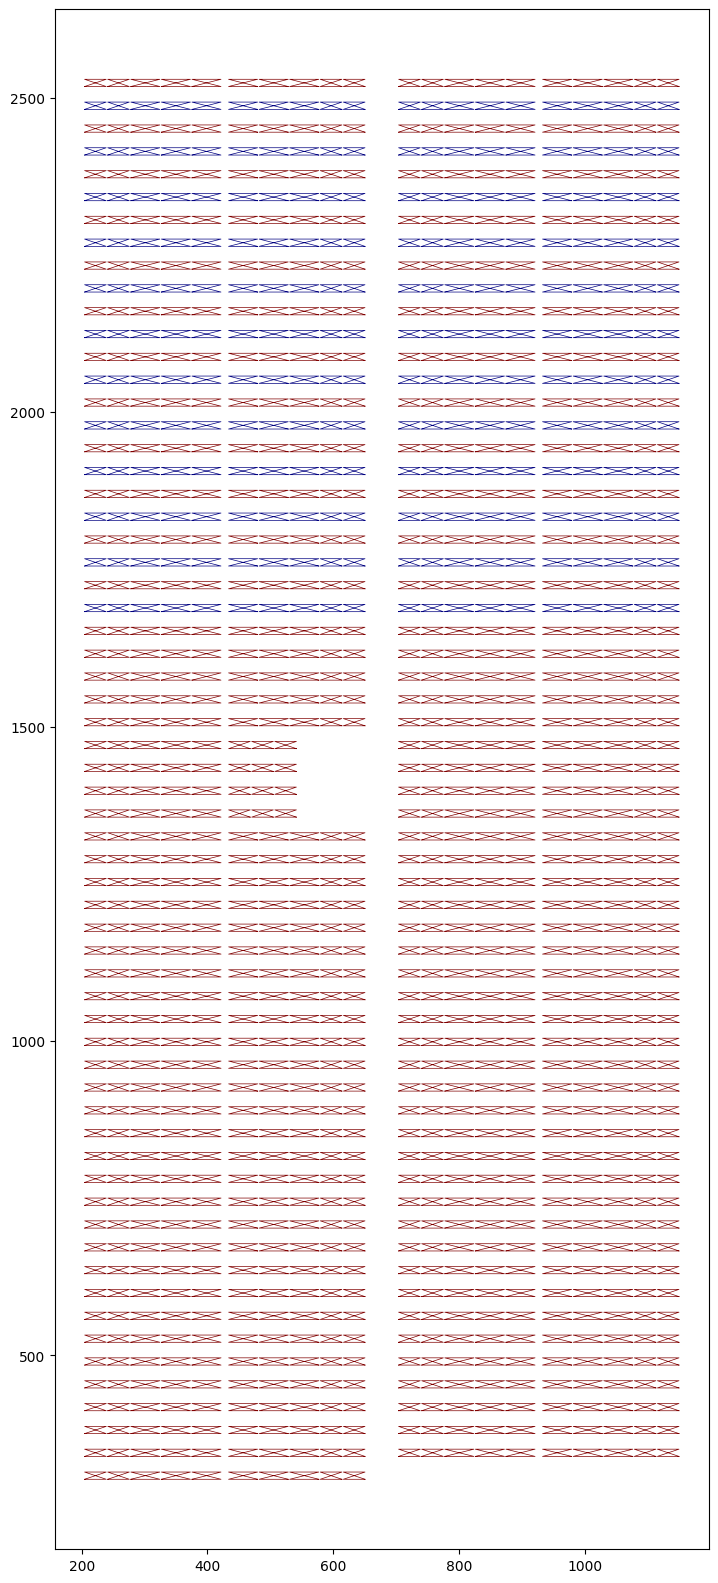

[-11.64013671875, -11.6400146484375, -11.639892578125, -11.52001953125, -11.5198974609375, -11.519775390625]


In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Collect all quad heights
quad_heights = []
quads = []
for path in layer_paths:
    for item in path.get("items", []):
        if item[0] == "qu":
            quad = item[1]
            pts = [quad[0], quad[1], quad[2], quad[3]]
            width = pts[0].y - pts[2].y
            height = ((pts[1].x - pts[2].x)**2 + (pts[1].y - pts[2].y)**2) ** 0.5
            quad_heights.append(width)
            quads.append((quad, width))

# Normalize heights for colormap
heights_arr = np.array(quad_heights)
if len(heights_arr) > 0:
    min_h, max_h = heights_arr.min(), heights_arr.max()
    norm = plt.Normalize(min_h, max_h) if max_h > min_h else lambda x: 0.5
else:
    norm = lambda x: 0.5

cmap = plt.get_cmap("jet")

fig, ax = plt.subplots(figsize=(20, 20))
for quad, height in quads:
    xs = [pt.x for pt in quad] + [quad[0].x]
    ys = [pt.y for pt in quad] + [quad[0].y]
    color = cmap(norm(height))
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_aspect("equal")
plt.show()
print(sorted(set(quad_heights)))

In [ ]:
[11.5, 11.599999999999909, 11.600000000000136, 11.600000000000364]

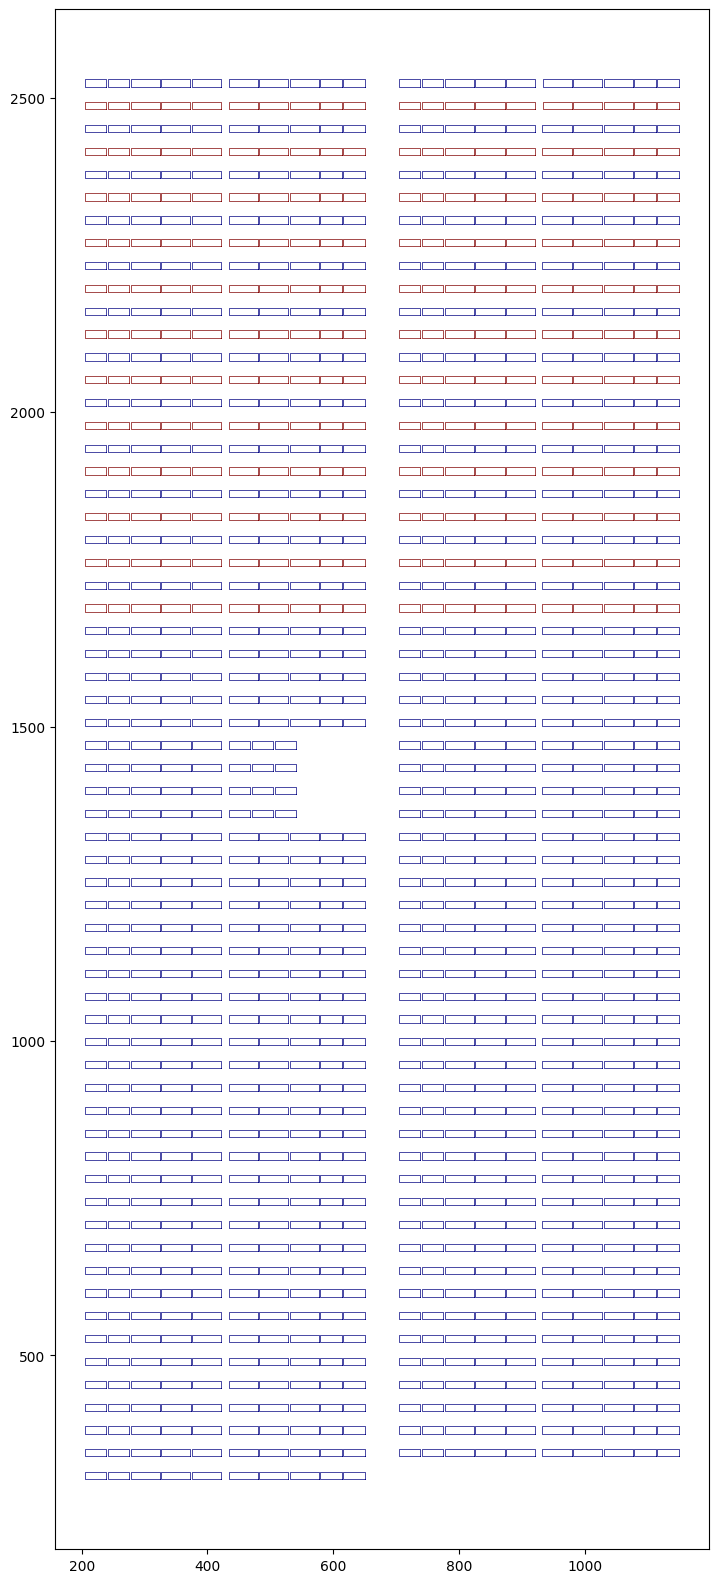

[11.519775390625,
 11.5198974609375,
 11.52001953125,
 11.639892578125,
 11.6400146484375,
 11.64013671875]

In [40]:
lines = extract_lines_from_paths(layer_paths, config)

import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import polygonize

polygons = list(polygonize(lines))

# Compute heights (delta y) for each polygon
heights = []
for poly in polygons:
    miny, maxy = poly.bounds[1], poly.bounds[3]
    heights.append(maxy - miny)

heights_arr = np.array(heights)
if len(heights_arr) > 0:
    min_h, max_h = heights_arr.min(), heights_arr.max()
    norm = plt.Normalize(min_h, max_h) if max_h > min_h else lambda x: 0.5
else:
    norm = lambda x: 0.5

cmap = plt.get_cmap("jet")

fig, ax = plt.subplots(figsize=(20, 20))
for poly, height in zip(polygons, heights):
    xs, ys = poly.exterior.xy
    color = cmap(norm(height))
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_aspect("equal")
plt.show()
sorted(set(heights))

In [ ]:
[11.5, 11.599999999999909, 11.600000000000136, 11.600000000000364]

In [42]:
page_number = 14
layers_dict = {
    'rack_outlines':        {'layer': "Xpanels - Northstar|E-PLAN-MCB",         'type': 'polygon', 'fill_lines': False},
    'combiner_boxes':       {'layer': "E-CB",                                   'type': 'rectangle', 'fill_lines': True},
    'ug_conduit':           {'layer': "E-UG_CONDUIT",                           'type': 'line', 'fill_lines': True},
    'ug_conduit_34.5kv':    {'layer': "E-UG_CONDUIT-34.5kV",                    'type': 'line', 'fill_lines': True},
    'ug_conduit_34.5kv_1ckt': {'layer': "E-UG_CONDUIT-34.5kV_1ckt",             'type': 'line', 'fill_lines': True},
    'inverter_boxed':       {'layer': "Xpanels - Northstar|E-Equipment",        'type': 'rectangle', 'fill_lines': False},
    'combiner_outlines':    {'layer': "E-CB_AREA",                              'type': 'polygon', 'fill_lines': True}
}
page_elements = extract_page_elements(file_path, page_number, config, layers_dict)


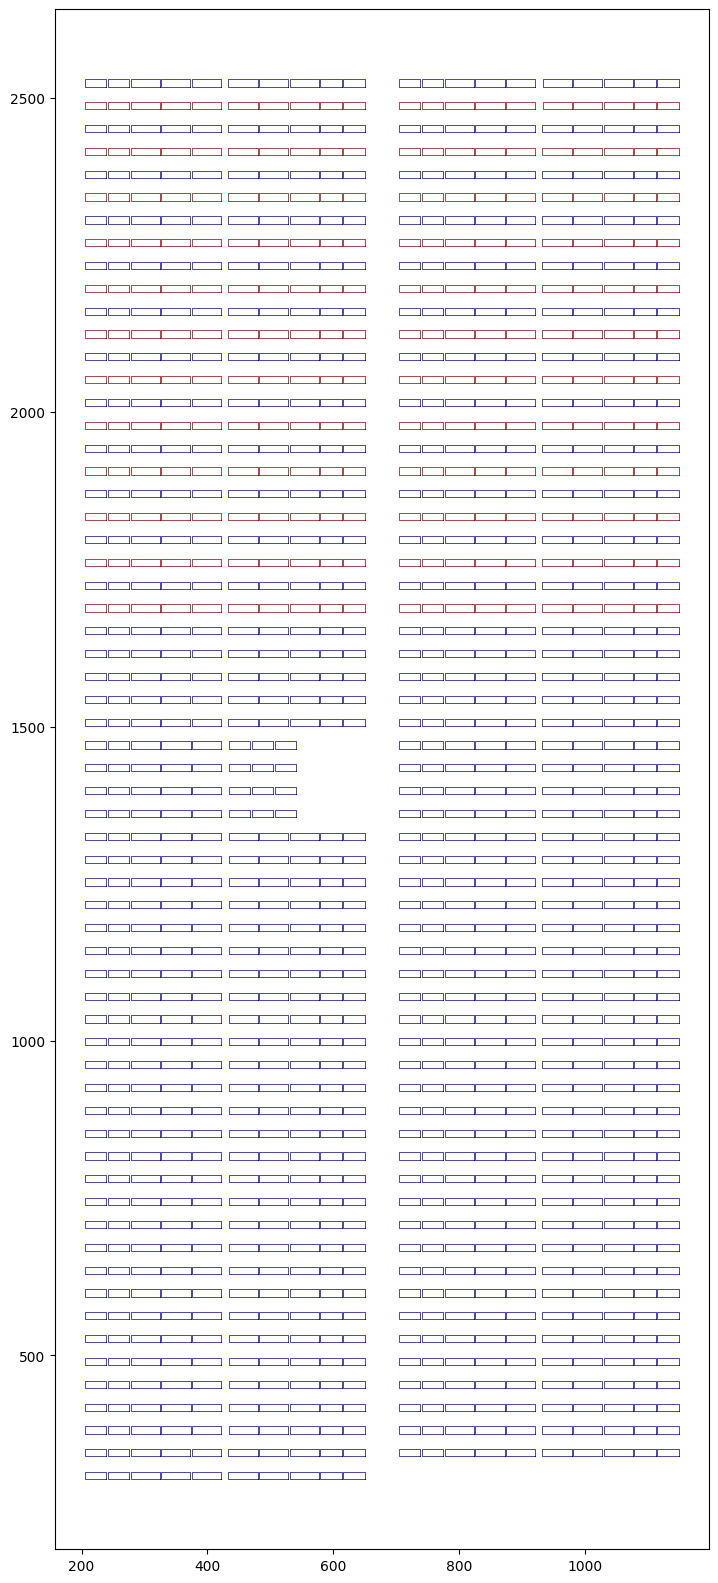

[11.5, 11.599999999999909, 11.600000000000136, 11.600000000000364]

In [41]:
import matplotlib.pyplot as plt
import numpy as np

rack_outlines = page_elements['rack_outlines']

# Compute y deltas (height) for each polygon
y_deltas = []
for poly in rack_outlines:
    miny, maxy = poly.bounds[1], poly.bounds[3]
    y_deltas.append(maxy - miny)

y_deltas_arr = np.array(y_deltas)
if len(y_deltas_arr) > 0:
    min_h, max_h = y_deltas_arr.min(), y_deltas_arr.max()
    norm = plt.Normalize(min_h, max_h) if max_h > min_h else lambda x: 0.5
else:
    norm = lambda x: 0.5

cmap = plt.get_cmap("jet")

fig, ax = plt.subplots(figsize=(20, 20))
for poly, y_delta in zip(rack_outlines, y_deltas):
    xs, ys = poly.exterior.xy
    color = cmap(norm(y_delta))
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_aspect("equal")
plt.show()

# Show unique y deltas
unique_y_deltas = sorted(set(y_deltas))
unique_y_deltas

In [19]:
lines

[<LINESTRING (874.52 339.52, 920.96 339.52)>,
 <LINESTRING (920.96 339.52, 920.96 351.04)>,
 <LINESTRING (920.96 351.04, 874.52 351.04)>,
 <LINESTRING (874.52 351.04, 874.52 339.52)>,
 <LINESTRING (825.92 339.52, 872.36 339.52)>,
 <LINESTRING (872.36 339.52, 872.36 351.04)>,
 <LINESTRING (872.36 351.04, 825.92 351.04)>,
 <LINESTRING (825.92 351.04, 825.92 339.52)>,
 <LINESTRING (777.32 339.52, 823.76 339.52)>,
 <LINESTRING (823.76 339.52, 823.76 351.04)>,
 <LINESTRING (823.76 351.04, 777.32 351.04)>,
 <LINESTRING (777.32 351.04, 777.32 339.52)>,
 <LINESTRING (1027.76 339.52, 981.44 339.52)>,
 <LINESTRING (981.44 339.52, 981.44 351.04)>,
 <LINESTRING (981.44 351.04, 1027.76 351.04)>,
 <LINESTRING (1027.76 351.04, 1027.76 339.52)>,
 <LINESTRING (1076.36 339.52, 1030.04 339.52)>,
 <LINESTRING (1030.04 339.52, 1030.04 351.04)>,
 <LINESTRING (1030.04 351.04, 1076.36 351.04)>,
 <LINESTRING (1076.36 351.04, 1076.36 339.52)>,
 <LINESTRING (979.16 339.52, 932.72 339.52)>,
 <LINESTRING (932.72 3

In [52]:
with open("layout_extended_13_63_running_record.pkl", "rb") as f:
    doc_json_v2 = pickle.load(f)

with open("layout_extended_14_15_running_record_20250806_211011.pkl", "rb") as f:
    doc_json_v3 = pickle.load(f)
rack_outlines = doc_json_v2[page_number]['page_elements']['rack_outlines']
#mls_rack_outlines = MultiLineString([list(poly.exterior.coords) for poly in rack_outlines])
#rack_outlines_transformed = affine_transform(mls_rack_outlines, affine_params_combiner_to_site)
rack_outlines_transformed = [affine_transform(poly, affine_params_combiner_to_site) for poly in rack_outlines]



In [41]:
polys = rack_outlines_transformed

vals = []
for p in polys:
    minx, miny, maxx, maxy = p.bounds
    vals.append(min(maxx - minx, maxy - miny))

list(set(vals))

[0.9050949619387438,
 1.2067932825848402,
 0.9050949619388575,
 1.2067932825850676,
 0.9050949619386301]

In [38]:
list(set(vals))

[1.1565102291440326,
 1.1665668398320577,
 1.1766234505203101,
 1.1565102291438052,
 1.166566839832285]

In [49]:
import align_racking_v3
importlib.reload(align_racking_v3)
params, out_mls, aoi = align_racking_v3.align_by_width_edge_rows_area(
        combiner_poly_site, site_polygons, rack_outlines_transformed, row_shift_range=3
    )

In [53]:
from shapely.geometry import mapping
import json

def to_geojson_feature(geom, properties=None):
    return {
        "type": "Feature",
        "geometry": mapping(geom),
        "properties": properties or {}
    }

def export_geojson(filename, rack_outlines, combiner_poly_site, site_polygons, layer_name):
    features = []
    features.append(to_geojson_feature(combiner_poly_site, {"layer": "combiner_poly_site"}))
    for poly in site_polygons:
        features.append(to_geojson_feature(poly, {"layer": "site_polygons"}))
    for poly in rack_outlines:
        features.append(to_geojson_feature(poly, {"layer": layer_name}))
    geojson = {
        "type": "FeatureCollection",
        "features": features
    }
    with open(filename, "w") as f:
        json.dump(geojson, f)

rack_outlines_v1 = doc_json[page_number]['page_elements']['rack_outlines']
rack_outlines_v2 = doc_json_v2[page_number]['page_elements']['rack_outlines']
rack_outlines_v3 = doc_json_v3[page_number]['page_elements']['rack_outlines']

export_geojson("exported_layers_v1.geojson", rack_outlines_v1, combiner_poly_site, site_polygons, "rack_outlines_v1")
export_geojson("exported_layers_v2.geojson", rack_outlines_v2, combiner_poly_site, site_polygons, "rack_outlines_v2")
export_geojson("exported_layers_v3.geojson", rack_outlines_v3, combiner_poly_site, site_polygons, "rack_outlines_v3")


In [47]:
doc_json_v3

{13: {'page_label': '1.1',
  'page_number': 13,
  'page_elements': {'rack_outlines': [<POLYGON ((955.3 370.4, 909 370.4, 909 381.9, 955.3 381.9, 955.3 370.4))>,
    <POLYGON ((906.7 370.4, 860.4 370.4, 860.4 381.9, 906.7 381.9, 906.7 370.4))>,
    <POLYGON ((858.1 370.4, 811.6 370.4, 811.6 381.9, 858.1 381.9, 858.1 370.4))>,
    <POLYGON ((1013.5 370.4, 967.2 370.4, 967.2 381.9, 1013.5 381.9, 1013.5 370.4))>,
    <POLYGON ((1062.1 370.4, 1015.8 370.4, 1015.8 381.9, 1062.1 381.9, 1062.1 37...>,
    <POLYGON ((1110.7 370.4, 1064.4 370.4, 1064.4 381.9, 1110.7 381.9, 1110.7 37...>,
    <POLYGON ((1147.4 370.4, 1113 370.4, 1113 381.9, 1147.4 381.9, 1147.4 370.4))>,
    <POLYGON ((1184.1 370.4, 1149.7 370.4, 1149.7 381.9, 1184.1 381.9, 1184.1 37...>,
    <POLYGON ((809.5 370.4, 775 370.4, 775 381.9, 809.5 381.9, 809.5 370.4))>,
    <POLYGON ((772.8 370.4, 738.3 370.4, 738.3 381.9, 772.8 381.9, 772.8 370.4))>,
    <POLYGON ((955.3 406, 909 406, 909 417.6, 955.3 417.6, 955.3 406))>,
    <POLYG

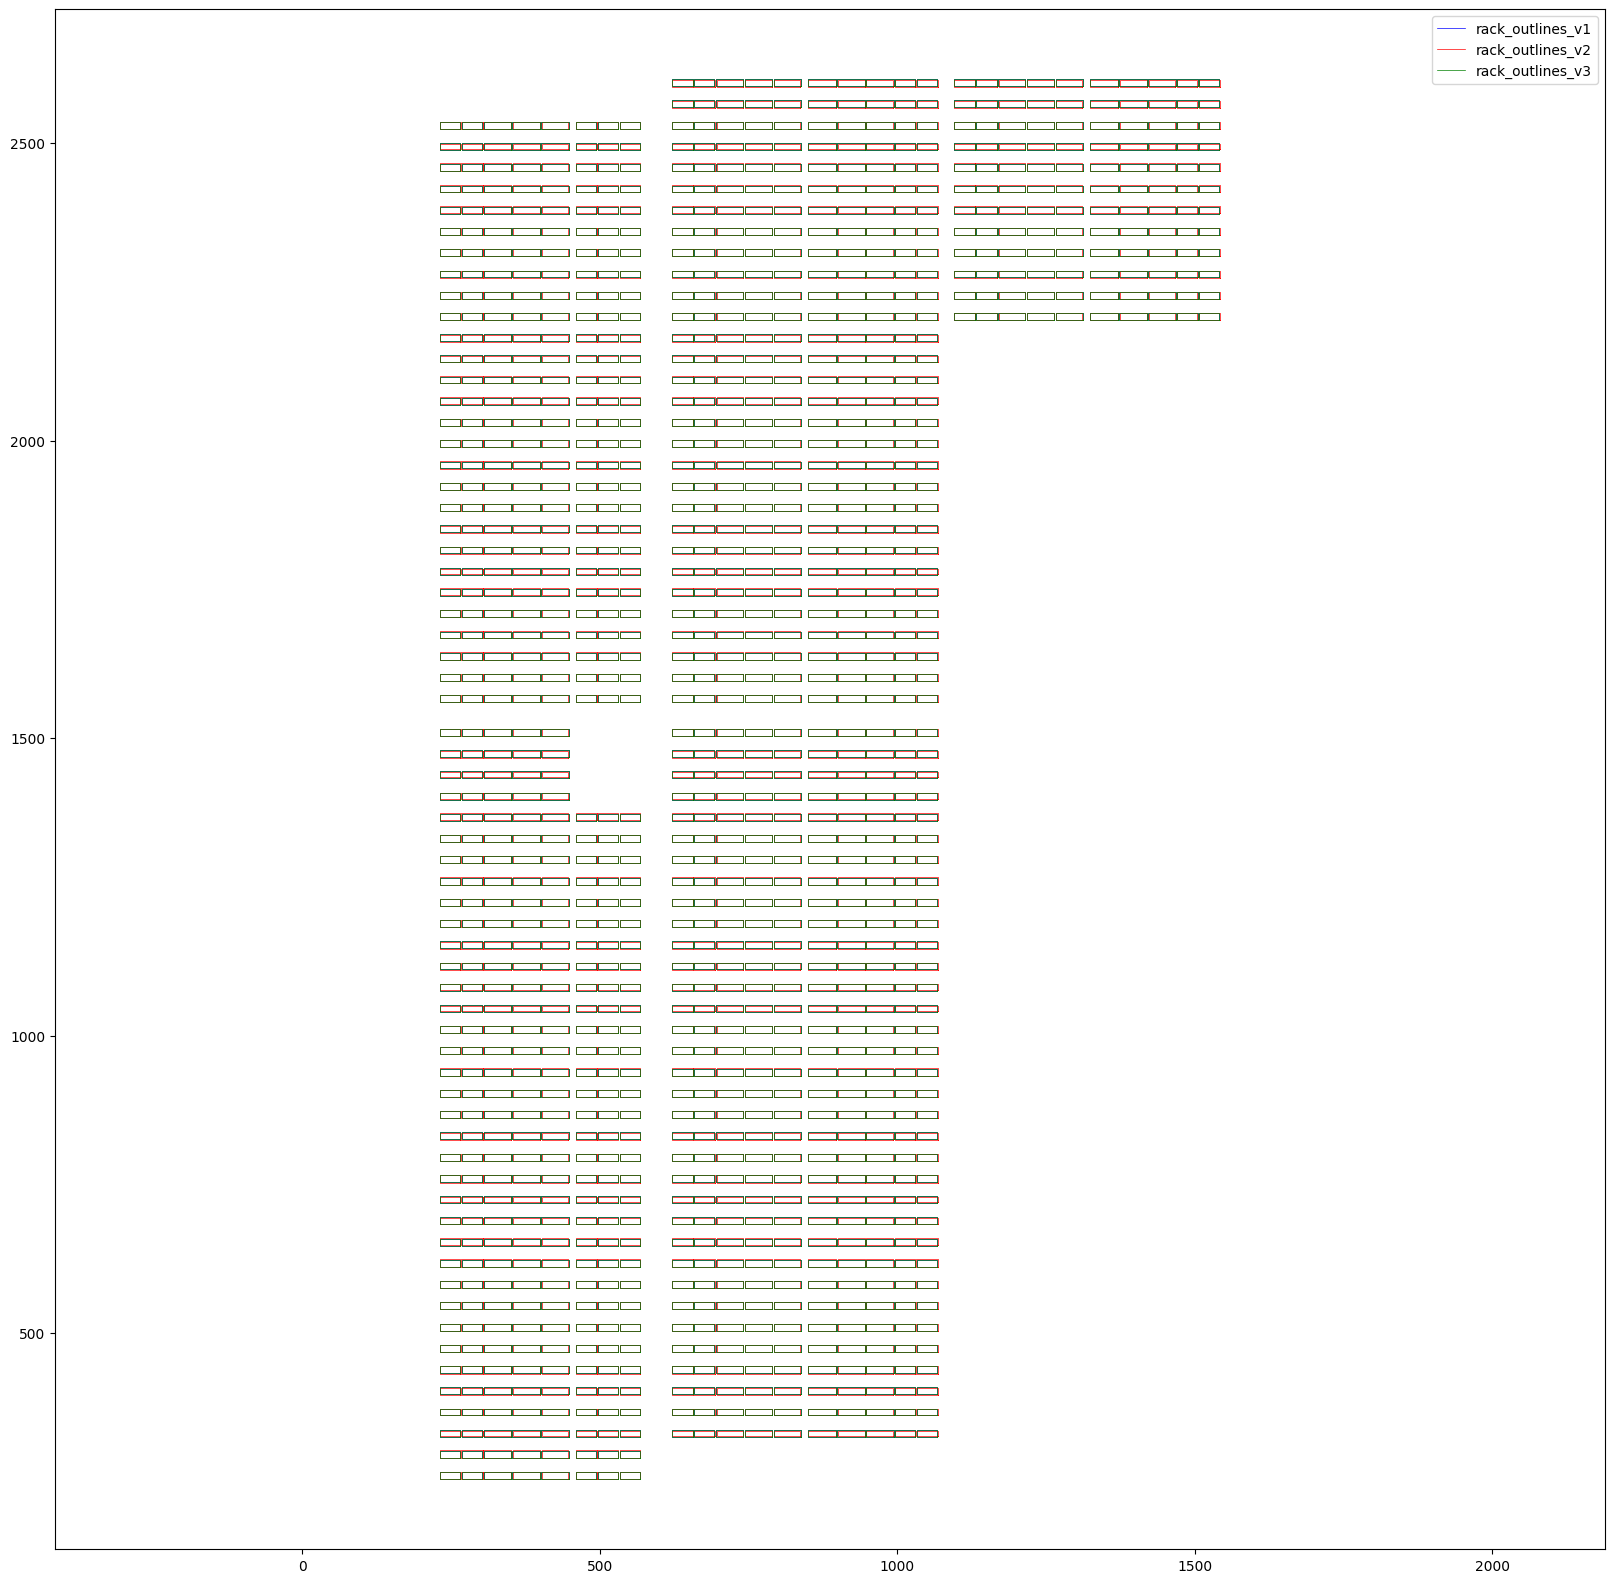

In [54]:
rack_outlines_v1 = doc_json[page_number]['page_elements']['rack_outlines']
rack_outlines_v2 = doc_json_v2[page_number]['page_elements']['rack_outlines']
rack_outlines_v3 = doc_json_v3[page_number]['page_elements']['rack_outlines']

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

def plot_polygons(polys, color, label):
    for poly in polys:
        if isinstance(poly, Polygon):
            x, y = poly.exterior.xy
            plt.plot(x, y, color=color, label=label,linewidth=0.5)
            label = None  # Only show label once

plt.figure(figsize=(20, 20))
plot_polygons(rack_outlines_v1, 'blue', 'rack_outlines_v1')
plot_polygons(rack_outlines_v2, 'red', 'rack_outlines_v2')
plot_polygons(rack_outlines_v3, 'green', 'rack_outlines_v3')
plt.legend()
plt.axis('equal')
plt.show()











In [ ]:
from shapely.geometry import shape, MultiLineString, MultiPolygon
import json
from align_racking import align_racking_affine_lines, Options

opts = Options(
    aoi_buffer_in_row_pitch=1.5,
    neighbor_max_in_row_pitch=1.2,
    source_line_buffer_abs=None,     # use 0.15 * pitch automatically
    simplify_tolerance=0.02,         # speedup
    iters=4
)

# Convert rack_outlines_transformed (list of polygons) to MultiLineString
rack_outlines_mls = MultiLineString([list(poly.exterior.coords) for poly in rack_outlines_transformed])

params, source_lines_xformed, aoi_buffer = align_racking_affine_lines(
    combiner_poly_site, polygons, rack_outlines_mls, opts
)


KeyboardInterrupt: 

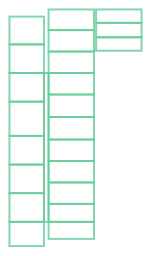

In [23]:
combiner_poly_site

In [26]:
rack_outlines

[<POLYGON ((838.2 325.8, 791.7 325.8, 791.7 337.4, 838.2 337.4, 838.2 325.8))>,
 <POLYGON ((789.6 325.8, 743.1 325.8, 743.1 337.4, 789.6 337.4, 789.6 325.8))>,
 <POLYGON ((741 325.8, 694.5 325.8, 694.5 337.4, 741 337.4, 741 325.8))>,
 <POLYGON ((896.4 325.8, 849.9 325.8, 849.9 337.4, 896.4 337.4, 896.4 325.8))>,
 <POLYGON ((945 325.8, 898.6 325.8, 898.6 337.4, 945 337.4, 945 325.8))>,
 <POLYGON ((993.6 325.8, 947.2 325.8, 947.2 337.4, 993.6 337.4, 993.6 325.8))>,
 <POLYGON ((1030.3 325.8, 995.8 325.8, 995.8 337.4, 1030.3 337.4, 1030.3 325.8))>,
 <POLYGON ((1067 325.8, 1032.6 325.8, 1032.6 337.4, 1067 337.4, 1067 325.8))>,
 <POLYGON ((692.4 325.8, 657.8 325.8, 657.8 337.4, 692.4 337.4, 692.4 325.8))>,
 <POLYGON ((655.6 325.8, 621.1 325.8, 621.1 337.4, 655.6 337.4, 655.6 325.8))>,
 <POLYGON ((838.2 361.6, 791.7 361.6, 791.7 373.1, 838.2 373.1, 838.2 361.6))>,
 <POLYGON ((789.6 361.6, 743.1 361.6, 743.1 373.1, 789.6 373.1, 789.6 361.6))>,
 <POLYGON ((741 361.6, 694.5 361.6, 694.5 373.1, 7

In [24]:
site_polygons

[<POLYGON ((1373.84 1274.92, 1329.2 1274.92, 1329.2 1276.12, 1373.84 1276.12,...>,
 <POLYGON ((1373.84 1278.64, 1329.2 1278.64, 1329.2 1279.72, 1373.84 1279.72,...>,
 <POLYGON ((1373.84 1282.24, 1329.2 1282.24, 1329.2 1283.32, 1373.84 1283.32,...>,
 <POLYGON ((1373.84 1285.84, 1329.2 1285.84, 1329.2 1287.04, 1373.84 1287.04,...>,
 <POLYGON ((1373.84 1289.44, 1329.2 1289.44, 1329.2 1290.64, 1373.84 1290.64,...>,
 <POLYGON ((1373.84 1293.16, 1329.2 1293.16, 1329.2 1294.24, 1373.84 1294.24,...>,
 <POLYGON ((1373.84 1296.76, 1329.2 1296.76, 1329.2 1297.84, 1373.84 1297.84,...>,
 <POLYGON ((1373.84 1300.36, 1329.2 1300.36, 1329.2 1301.56, 1373.84 1301.56,...>,
 <POLYGON ((1373.84 1303.96, 1329.2 1303.96, 1329.2 1305.16, 1373.84 1305.16,...>,
 <POLYGON ((1373.84 1307.68, 1329.2 1307.68, 1329.2 1308.76, 1373.84 1308.76,...>,
 <POLYGON ((1373.84 1311.28, 1329.2 1311.28, 1329.2 1312.36, 1373.84 1312.36,...>,
 <POLYGON ((1373.84 1314.88, 1329.2 1314.88, 1329.2 1316.08, 1373.84 1316.08,...>,
 <PO

In [25]:
rack_outlines_transformed

[<POLYGON ((475.601 1013.537, 470.925 1013.537, 470.925 1014.703, 475.601 101...>,
 <POLYGON ((470.714 1013.537, 466.037 1013.537, 466.037 1014.703, 470.714 101...>,
 <POLYGON ((465.826 1013.537, 461.15 1013.537, 461.15 1014.703, 465.826 1014....>,
 <POLYGON ((481.454 1013.537, 476.778 1013.537, 476.778 1014.703, 481.454 101...>,
 <POLYGON ((486.341 1013.537, 481.675 1013.537, 481.675 1014.703, 486.341 101...>,
 <POLYGON ((491.229 1013.537, 486.563 1013.537, 486.563 1014.703, 491.229 101...>,
 <POLYGON ((494.92 1013.537, 491.45 1013.537, 491.45 1014.703, 494.92 1014.70...>,
 <POLYGON ((498.611 1013.537, 495.151 1013.537, 495.151 1014.703, 498.611 101...>,
 <POLYGON ((460.938 1013.537, 457.459 1013.537, 457.459 1014.703, 460.938 101...>,
 <POLYGON ((457.238 1013.537, 453.768 1013.537, 453.768 1014.703, 457.238 101...>,
 <POLYGON ((475.601 1017.137, 470.925 1017.137, 470.925 1018.294, 475.601 101...>,
 <POLYGON ((470.714 1017.137, 466.037 1017.137, 466.037 1018.294, 470.714 101...>,
 <PO

In [22]:
print(affine_params_combiner_to_site)
print(affine_params_combiner_to_inverter)
print(affine_params_inverter_to_site)
print(fine_tune_affine)


[0.10056610688207569, 0.0, 0.0, 0.10056610688207569, 391.30650609782697, 980.7722996534012]
[0.03359884755529193, 0, 0, 0.03359884755529193, 1369.9831010083892, 401.2734090331328]
[2.993141556911412, 0, 0, 2.993141556911412, -3709.246845796748, -220.29581660717986]
[1.0375620912262533, 0.0, 0.0, 1.0375620912262533, -16.8473048445568, -45.67706249958184]


c:\Users\roba7\Documents\Programming projects\as-built-processing\pdf_layout_extraction_dev\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


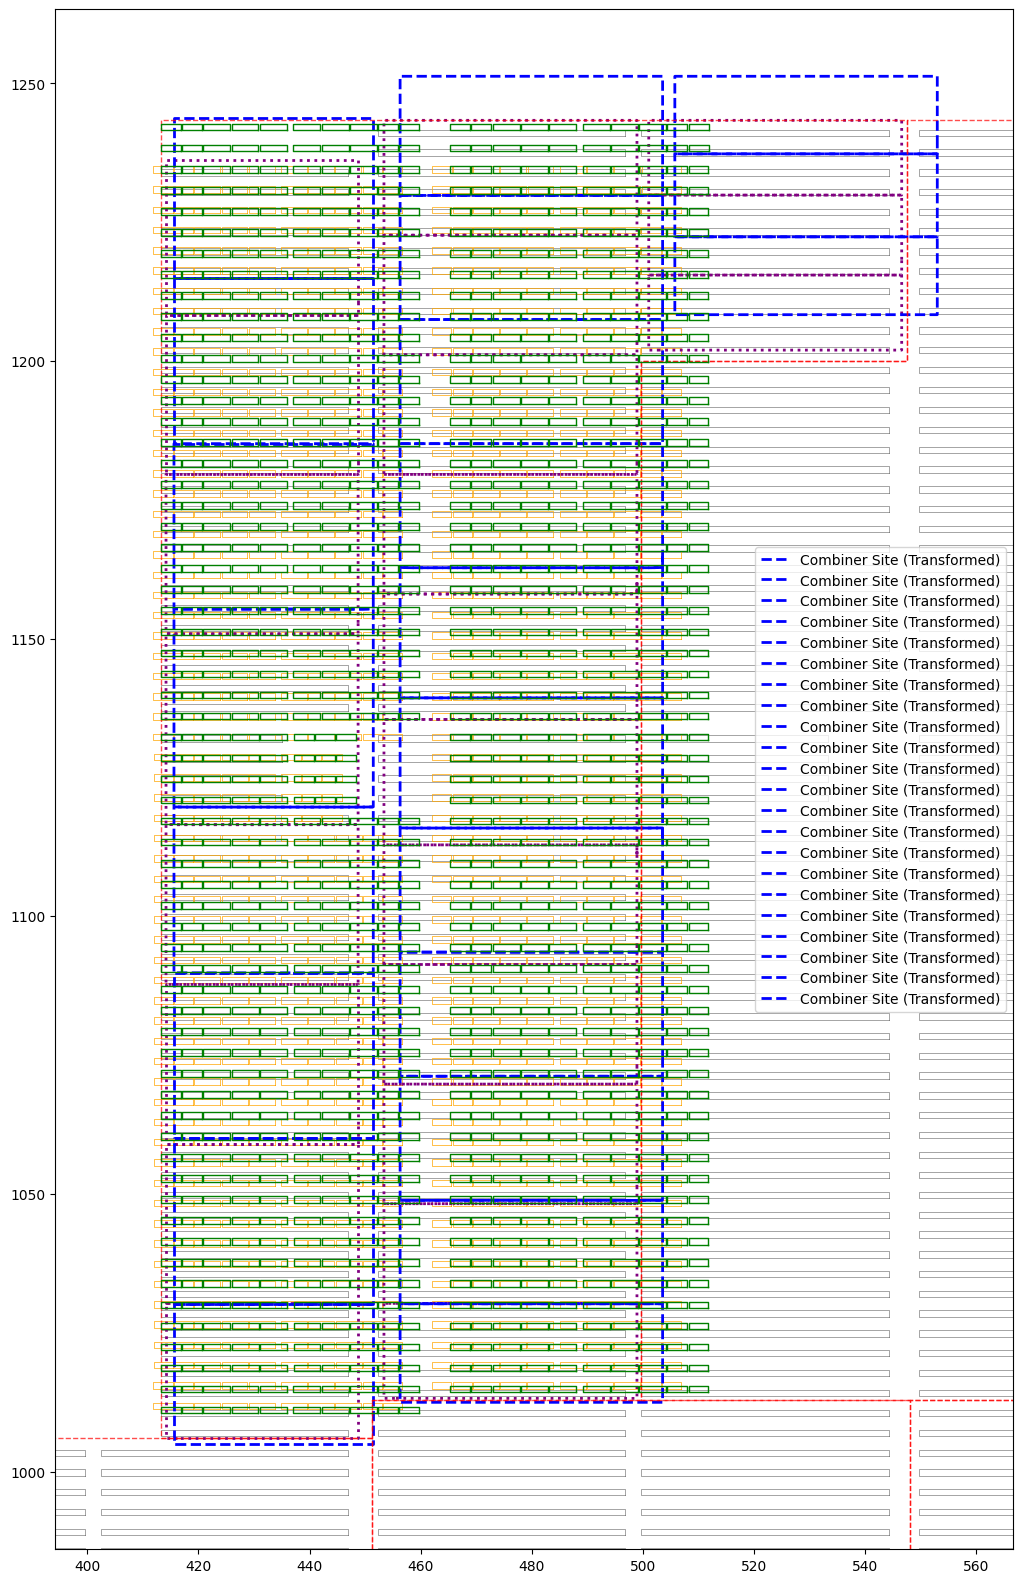

In [48]:
import matplotlib.pyplot as plt

import importlib, align_racking_v2
importlib.reload(align_racking_v2)




fig, ax = plt.subplots(figsize=(20, 20))
all_x = []
all_y = []

# Plot polygons
for poly in site_polygons:
    x, y = poly.exterior.xy
    ax.plot(x, y, color='grey', linewidth=0.5)
    all_x.extend(x)
    all_y.extend(y)

# Plot rack_outlines_transformed
for poly in rack_outlines_transformed:
    x, y = poly.exterior.xy
    ax.plot(x, y, color='orange', linewidth=0.5)


# Plot combiner_poly_site (MultiLineString)
for line in combiner_poly_site.geoms:
    x, y = line.xy
    ax.plot(x, y, color='purple', linewidth=2, linestyle=':')

from shapely import affinity


# Plot transformed combiner_poly_site
for line in combiner_poly_site_transformed.geoms:
    x, y = line.xy
    ax.plot(x, y, color='blue', linewidth=2, linestyle='--', label='Combiner Site (Transformed)')


# Plot transformed source MultiLineString
for line in transformed_source.geoms:
    x, y = line.xy
    ax.plot(x, y, color='red', linewidth=1, alpha=0.7, linestyle='--')

# Plot out_mls
if out_mls.geom_type == 'MultiLineString':
    for line in out_mls.geoms:
        x, y = line.xy
        ax.plot(x, y, color='green', linewidth=1, linestyle='-')
elif out_mls.geom_type == 'LineString':
    x, y = out_mls.xy
    ax.plot(x, y, color='green', linewidth=1, linestyle='-')

min_x, max_x = min(all_x), max(all_x)
min_y, max_y = min(all_y), max(all_y)
width = max_x - min_x
height = max_y - min_y
# Set xlim, ylim to combiner_poly_site bounds plus 20 buffer
minx, miny, maxx, maxy = combiner_poly_site.bounds
ax.set_xlim(minx - 20, maxx + 20)
ax.set_ylim(miny - 20, maxy + 20)
ax.set_aspect('equal')
ax.legend()
plt.show()

c:\Users\roba7\Documents\Programming projects\as-built-processing\pdf_layout_extraction_dev\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


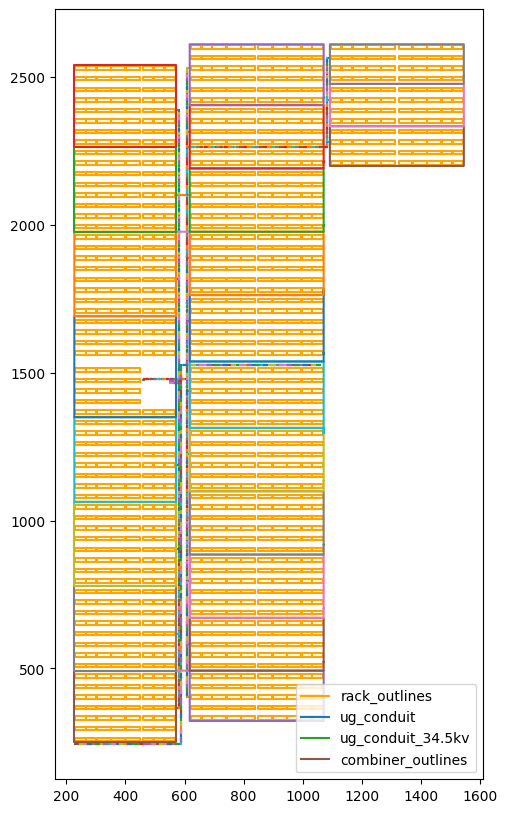

In [28]:
import matplotlib.pyplot as plt

page_elements = doc_json[page_number]['page_elements']

fig, ax = plt.subplots(figsize=(10, 10))

colors = {
    'rack_outlines': 'orange',
    'combiner_poly_site': 'purple',
    'combiner_poly_site_transformed': 'blue',
    'transformed_source': 'red',
    'out_mls': 'green'
}

for key, value in page_elements.items():
    if not value:
        continue
    if isinstance(value, list):
        for geom in value:
            # Try to plot as polygon (with exterior), else as rectangle (with bounds)
            if hasattr(geom, 'exterior'):
                x, y = geom.exterior.xy
                ax.plot(x, y, color=colors.get(key, None), label=key if key not in ax.get_legend_handles_labels()[1] else "")
            elif hasattr(geom, 'bounds'):
                minx, miny, maxx, maxy = geom.bounds
                x = [minx, maxx, maxx, minx, minx]
                y = [miny, miny, maxy, maxy, miny]
                ax.plot(x, y, color=colors.get(key, None), label=key if key not in ax.get_legend_handles_labels()[1] else "")
    else:
        if hasattr(value, 'geoms'):
            for line in value.geoms:
                x, y = line.xy
                ax.plot(x, y, color=colors.get(key, None), label=key if key not in ax.get_legend_handles_labels()[1] else "")
        elif hasattr(value, 'xy'):
            x, y = value.xy
            ax.plot(x, y, color=colors.get(key, None), label=key if key not in ax.get_legend_handles_labels()[1] else "")

ax.set_aspect('equal')
ax.legend()
plt.show()

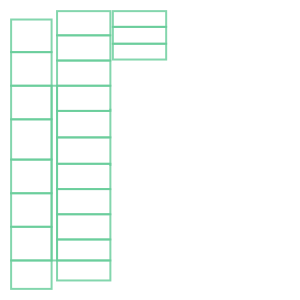

In [11]:
mls_combiners

In [12]:
affine_params_combiner_to_site

[nan, nan, nan, nan, nan, nan]

In [13]:
affine_params_combiner_to_inverter

[0.03359884755529193,
 0,
 0,
 0.03359884755529193,
 1369.9831010083892,
 401.2734090331328]

In [14]:
affine_params_inverter_to_site

[nan, 0, 0, nan, nan, nan]

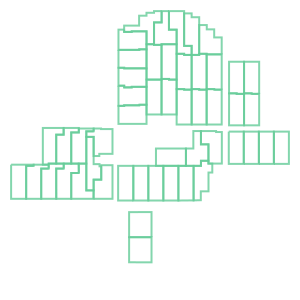

In [15]:
mls_inverter_full_site

In [16]:
mls

In [7]:
rack_outlines

[<POLYGON ((838.2 325.8, 791.7 325.8, 791.7 337.4, 838.2 337.4, 838.2 325.8))>,
 <POLYGON ((789.6 325.8, 743.1 325.8, 743.1 337.4, 789.6 337.4, 789.6 325.8))>,
 <POLYGON ((741 325.8, 694.5 325.8, 694.5 337.4, 741 337.4, 741 325.8))>,
 <POLYGON ((896.4 325.8, 849.9 325.8, 849.9 337.4, 896.4 337.4, 896.4 325.8))>,
 <POLYGON ((945 325.8, 898.6 325.8, 898.6 337.4, 945 337.4, 945 325.8))>,
 <POLYGON ((993.6 325.8, 947.2 325.8, 947.2 337.4, 993.6 337.4, 993.6 325.8))>,
 <POLYGON ((1030.3 325.8, 995.8 325.8, 995.8 337.4, 1030.3 337.4, 1030.3 325.8))>,
 <POLYGON ((1067 325.8, 1032.6 325.8, 1032.6 337.4, 1067 337.4, 1067 325.8))>,
 <POLYGON ((692.4 325.8, 657.8 325.8, 657.8 337.4, 692.4 337.4, 692.4 325.8))>,
 <POLYGON ((655.6 325.8, 621.1 325.8, 621.1 337.4, 655.6 337.4, 655.6 325.8))>,
 <POLYGON ((838.2 361.6, 791.7 361.6, 791.7 373.1, 838.2 373.1, 838.2 361.6))>,
 <POLYGON ((789.6 361.6, 743.1 361.6, 743.1 373.1, 789.6 373.1, 789.6 361.6))>,
 <POLYGON ((741 361.6, 694.5 361.6, 694.5 373.1, 7